## This handbook describes some ways to estimate parameters for a Poisson mixture model:

### EM algorithm

### Gibbs sampling

### Use rstan (Hamiltonian sampling)

### Use Variational Bayesian methods

### Use optimization functions built in R

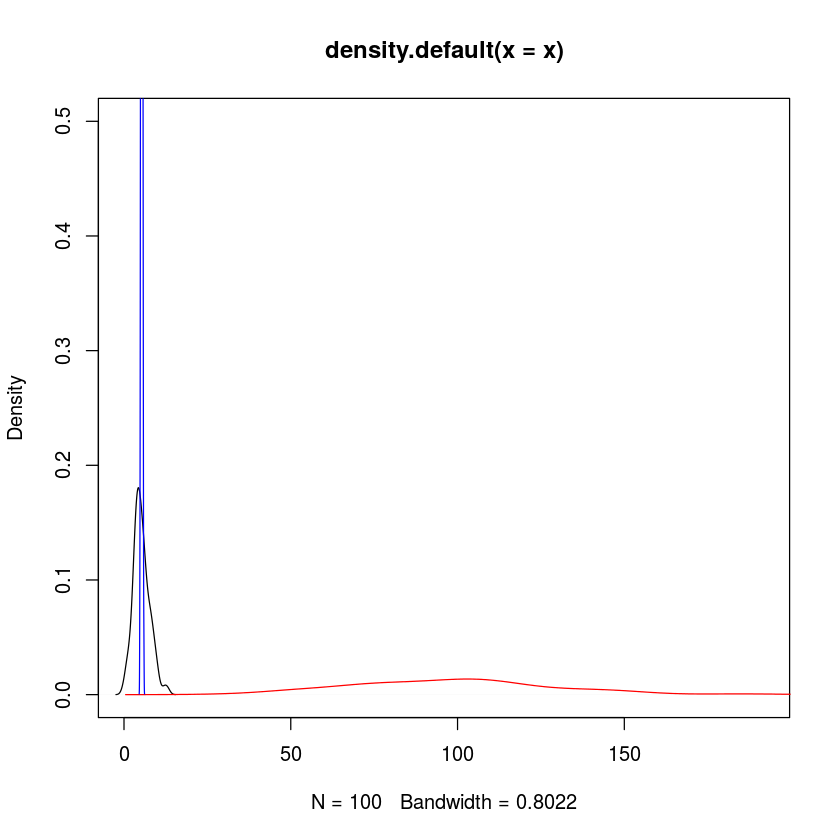

In [6]:
##This describes some methods to estimate parameters
##x ~ poisson(lambda); lambda ~ gamma(alpha, beta); lambda|x ~ gamma(alpha + x, beta + n)

lambda0 <- 5
N <- 100
x <- rpois(N, lambda0)

alpha0 <- 10
beta0 <- 0.1
prior <- rgamma(N, alpha0, rate = beta0)

postLambda <- rgamma(N, alpha0 + sum(x), rate = beta0 + N)

plot(density(x), xlim = range(c(x, prior, postLambda)), ylim = c(0, 0.5))
lines(density(prior), col = 'red')
lines(density(postLambda), col = 'blue')



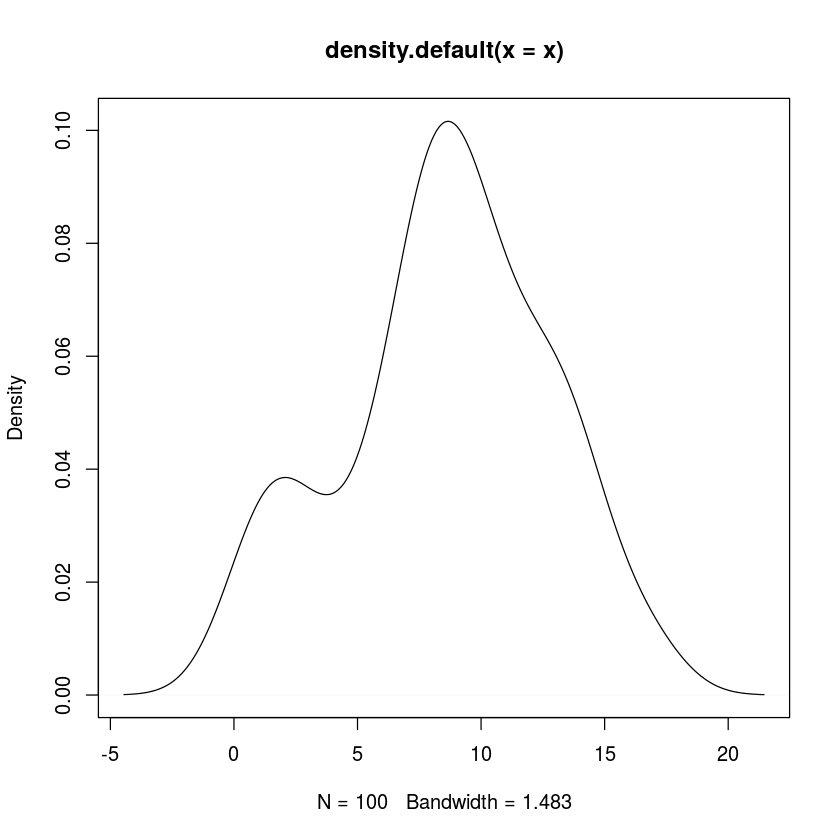

In [8]:
pi0 <- 0.2
mu1 <- 2
mu2 <- 10
x1 <- rpois(N, mu1)
x2 <- rpois(N, mu2)
x <- apply(cbind(x1, x2), 1, function(x) sample(x, 1, prob = c(pi0, 1 - pi0)))
plot(density(x))



### EM 

,piOut,,
"[995,]",0.1626613,1.8266206,9.9038527
"[996,]",0.1626613,1.8266206,9.9038527
"[997,]",0.1626613,1.8266206,9.9038527
"[998,]",0.1626613,1.8266206,9.9038527
"[999,]",0.1626613,1.8266206,9.9038527
"[1000,]",0.1626613,1.8266206,9.9038527


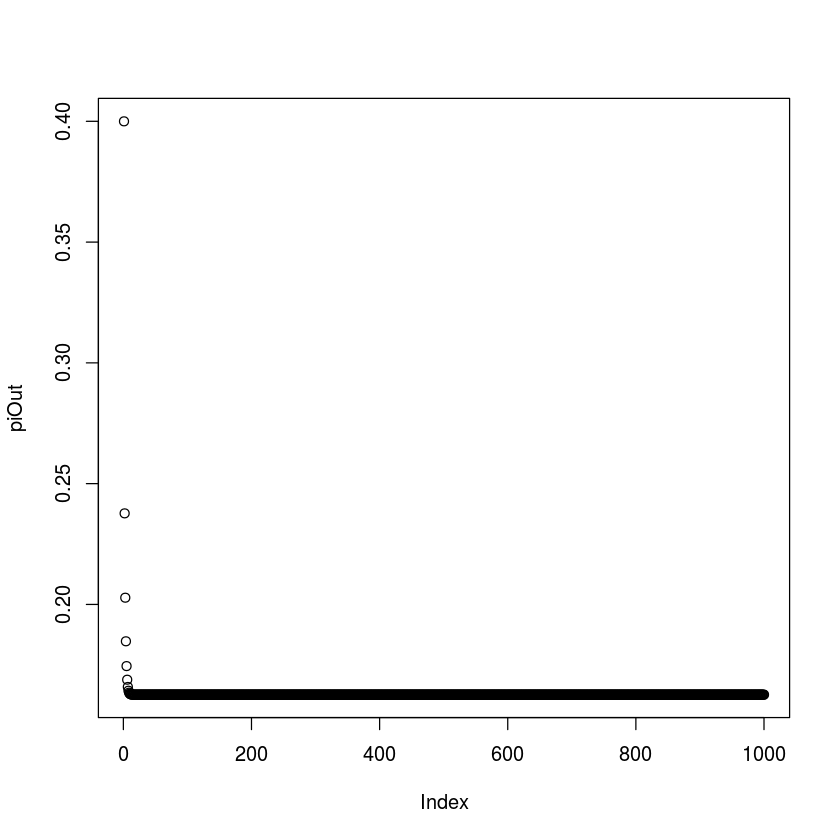

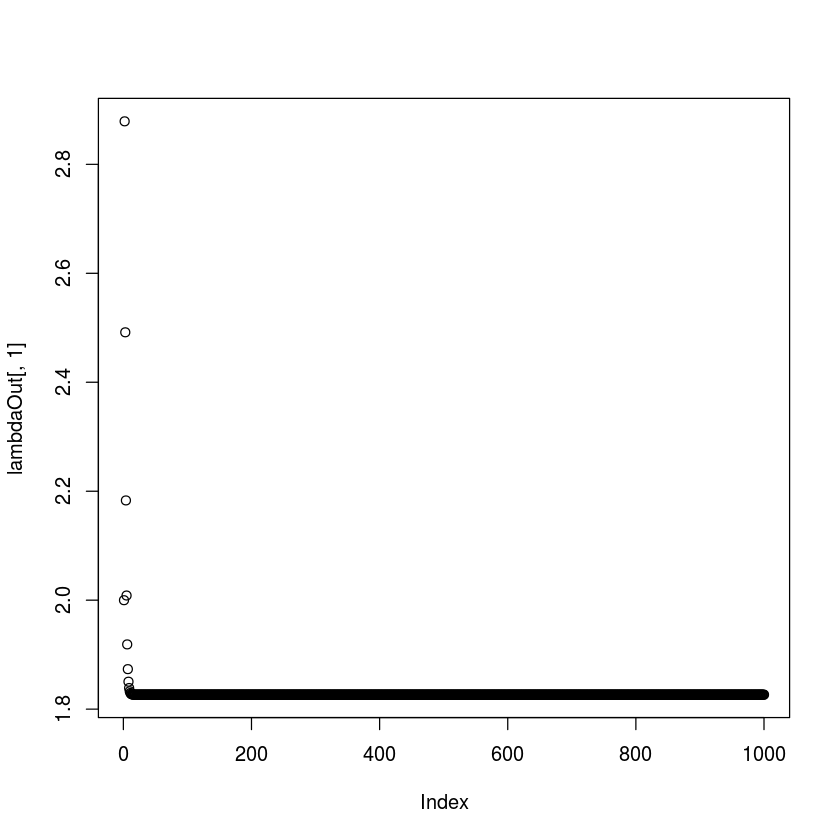

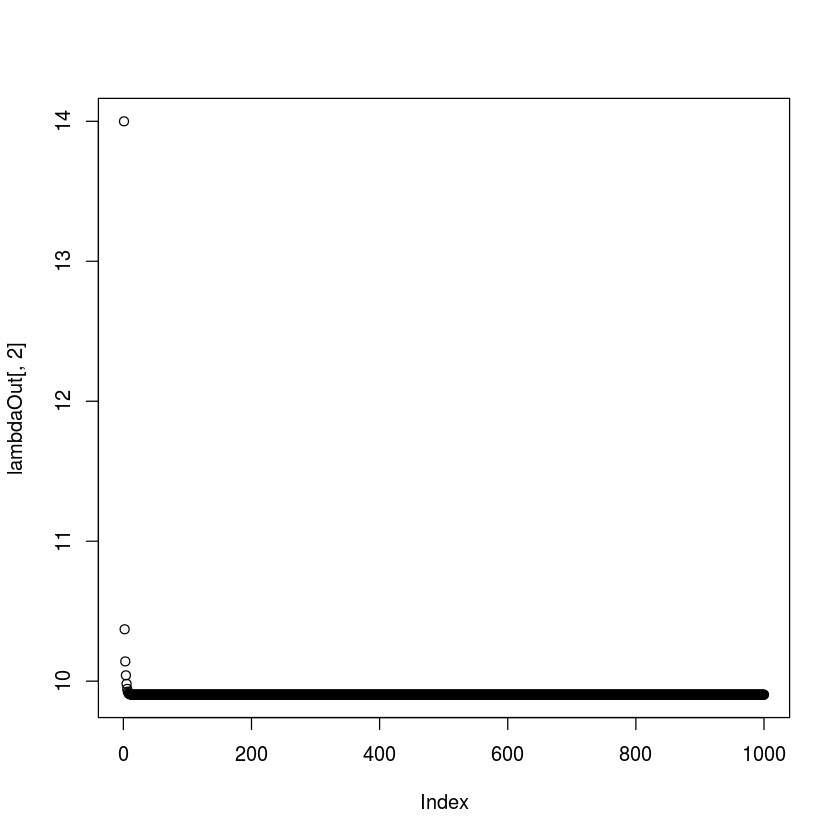

In [11]:
############################
### Em    #######
Nloop <- 1000
wij <- matrix(0, ncol = 2, nrow = length(x))
piOut <- rep(0, Nloop)
lambdaOut <- matrix(0, ncol = 2, nrow = Nloop)

###Choose initial values
piOut[1] <- 0.4
lambdaOut[1, ] <- quantile(x, c(0.1, 0.9))
f1 <- piOut[1]*dpois(x, lambdaOut[1, 1])
f2 <- (1 - piOut[1])*dpois(x, lambdaOut[1, 2])
wij[, 1] <- f1/(f1 + f2)
wij[, 2] <- f2/(f1 + f2)

for (i in 2:Nloop){
  piOut[i] <- sum(wij[, 1])/sum(wij)
  lambdaOut[i, 1] <- sum(wij[, 1]*x)/sum(wij[, 1])
  lambdaOut[i, 2] <- sum(wij[, 2]*x)/sum(wij[, 2])

  ##Re calculate expectation values
  f1 <- piOut[i]*dpois(x, lambdaOut[i, 1])
  f2 <- (1 - piOut[i])*dpois(x, lambdaOut[i, 2])
  wij[, 1] <- f1/(f1 + f2)
  wij[, 2] <- f2/(f1 + f2)
  
}

tail(cbind(piOut, lambdaOut))
plot(piOut)
plot(lambdaOut[, 1])
plot(lambdaOut[, 2])



### GIBBS SAMPLING

lambda1     lambda2         pi1 Ratio_loglk 
  1.8848172   9.8927110   0.1783488   0.9996290

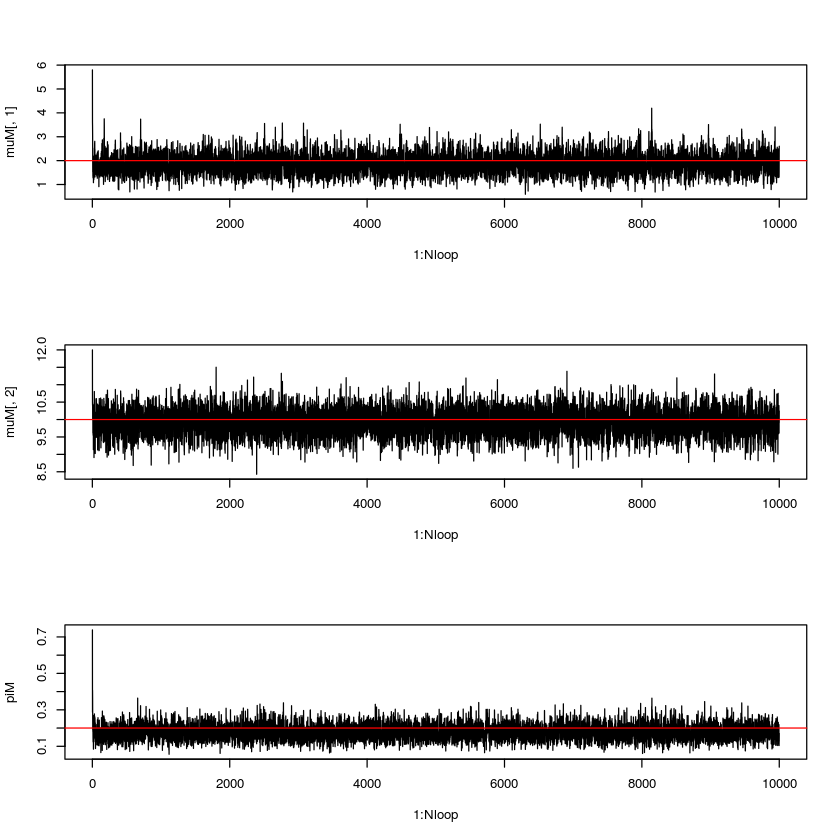

In [12]:

#############GIBSS
Nloop <- 10000
K <- 2
piM <- rep(0, Nloop)
muM <<- matrix(0, nrow = Nloop, ncol = K)

a0 <- c(2, 2) ##Prior information for proportions
##Initial values
i = 1
piM[i] <- rbeta(1, 1, 1)
###Lambda
muM[i, ] <- quantile(x, c(0.2, 0.8))
###Latent variables
z <- rbinom(N, 1, piM[i]) + 1
###Count for the first group
n1 <- n2 <- rep(0, length(x))
i = 1
n1[i] <- length(z[z == 1]) ##Count for the 1st group
n2[i] <- N - n1[i] ## Count for the 2nd group

loglk <- function(prob0, lambda0, x0){
  sum(log(prob0[1]*dpois(x0, lambda0[1]) + prob0[2]*dpois(x0, lambda0[2])))
}
##piM*Poisson(mu1) + (1 - pi0)*Poisson(mu2)
rLLK <- rep(1, length(x))
for (i in 2:Nloop){
  ##Posterior probabily for the first group with prior Dirichlet(alpha0)
  piM[i] <- rbeta(1, n1[i-1] + a0[1], n2[i-1] + a0[2]) 
  
  ##Update group probability for each data points
  p1 <- piM[i]*dpois(x, muM[i -1,1])/(piM[i]*dpois(x, muM[i -1,1]) + (1 - piM[i])*dpois(x, muM[i-1, 2]))
  
  ##Update latent variables for each data points
  z <- rbinom(N, 1, p1) 
  n1[i] <- length(z[z == 1]) ##Count for the 1st group
  n2[i] <- N - n1[i] ## Count for the 2nd group

    if (n1[i] > n2[i]){ ###Avoid label switching
        tempSwap <- n1[i]
        n1[i] <- n2[i]
        n2[i] <- tempSwap}
    
  ##Update mu0
  alpha0 <- c(2, 10)
  beta0 <- c(1, 1)
  
  prior <- rgamma(N, alpha0, rate = beta0)
  
  x1 <- x[z==1] ##Group 1
  x2 <- x[z!=1] ##Group 2
  muM[i, 1] <- rgamma(1, alpha0[1] + sum(x1), rate = beta0[1] + length(x1)) ##Posterior of lambda1
  muM[i, 2] <- rgamma(1, alpha0[2] + sum(x2), rate = beta0[2] + length(x2)) ##Posterior of lambda2
  
  ################Finish Gibbs sampling
  ###Add one Metropolis rejection step
  oldLLK <- loglk(c(piM[i-1], 1 - piM[i-1]), muM[i-1, ], x)
  newLLK <- loglk(c(piM[i  ], 1 - piM[i  ]), muM[i, ], x)
  rLLK[i] <- newLLK/oldLLK
  
#  if (runif(1) > newLLK/oldLLK){
 #   muM[i, ] <- muM[i-1, ]
  #  n1[i] <- n1[i-1]
   # n2[i] <- n2[i-1]
  #}
  
}

par(mfrow = c(3, 1))
plot(1:Nloop, muM[, 1], type = 'l')
abline(h = mu1, col = 'red')
plot(1:Nloop, muM[, 2], type = 'l')
abline(h = mu2, col = 'red')

plot(1:Nloop, piM, type = 'l')
abline(h = pi0, col = 'red')

outData <- cbind(muM, piM, rLLK)
outData1 <- outData[outData[, 3] < 0.5,]

nBurnin <- Nloop/2
outData <- outData[(nBurnin + 1):Nloop, ]
nThin <- floor(dim(outData)[1]/1000)
x1 <- seq(1, dim(outData)[1], by = nThin)

colnames(outData) <- c("lambda1", "lambda2", "pi1", "Ratio_loglk")
outData <- outData[x1, ]
apply(outData, 2, mean)


### USE RSTAN package

Inference for Stan model: 756a9c3729dd24dbcec3102035e5c043.
2 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=2000.

              mean se_mean   sd    2.5%     25%     50%     75%   97.5% n_eff
pi0[1]        0.17    0.00 0.04    0.10    0.14    0.17    0.20    0.26  1342
pi0[2]        0.83    0.00 0.04    0.74    0.80    0.83    0.86    0.90  1342
lambda0[1]    1.85    0.01 0.41    1.13    1.56    1.83    2.12    2.71  1182
lambda0[2]    9.91    0.01 0.36    9.17    9.67    9.91   10.14   10.61  1494
lp__       -266.79    0.05 1.22 -269.83 -267.33 -266.49 -265.92 -265.41   509
           Rhat
pi0[1]        1
pi0[2]        1
lambda0[1]    1
lambda0[2]    1
lp__          1

Samples were drawn using NUTS(diag_e) at Thu Feb  4 22:40:10 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

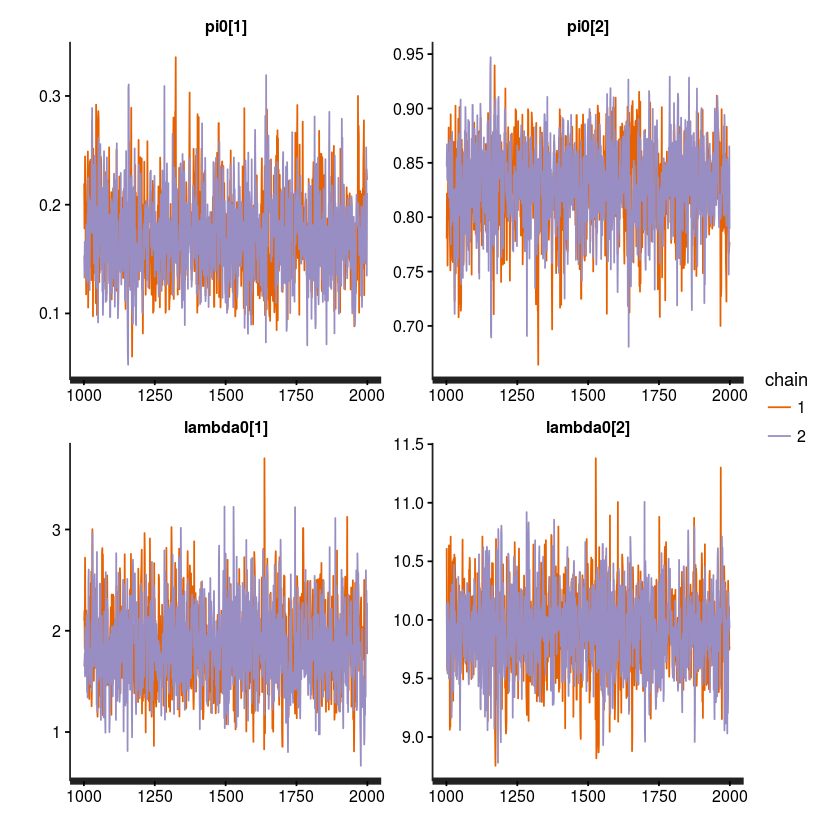

In [9]:
pModel <- "data {
    int<lower=1> N;
    int x[N];
real alpha0[2];
real beta0[2];
vector[2] a0;
  }
parameters {
  simplex[2] pi0;
//real<lower=0> pi0;
  real<lower=0.05> lambda0[2];
}
model {
  real ps[2];
pi0 ~ dirichlet(a0);
//pi0 ~ uniform(0.001, 0.4);
lambda0[1] ~ gamma(alpha0[1], beta0[1]);
lambda0[2] ~ gamma(alpha0[2], beta0[2]);
  for (i in 1:N){
    ps[1] <- log(pi0[1]) + poisson_log(x[i], lambda0[1]);
    ps[2] <- log(pi0[2]) + poisson_log(x[i], lambda0[2]);
    
    increment_log_prob(log_sum_exp(ps));
  }
}"

pData <- list(x = x, N = length(x),   
              alpha0 = c(2, 10),
              beta0  = c(1, 1),
              a0 = c(1, 1))

initValues <- list(list(lambda0 = quantile(x, c(0.2, 0.8))),
                   list(lambda0 = quantile(x, c(0.3, 0.7))))
testFit <- stan(model_code = pModel, data = pData, chains = 2, cores = 2, init = initValues)
testFit
##pdf("poissonLabelSwitching.pdf")
stan_trace(testFit)


### Use Variational Bayesian methods in the rstan package

In [10]:
NSample <- 500000
nSeed1 <- floor(runif(1, 1, 10^6))
pMM <- stan_model(model_code = pModel)
vMM <- vb(pMM, seed = nSeed1,
                    data = pData,
                    iter = NSample, output_samples= 1000)
vMM




This is Automatic Differentiation Variational Inference.

(EXPERIMENTAL ALGORITHM: expect frequent updates to the procedure.)

Gradient evaluation took 9.8e-05 seconds
1000 iterations under these settings should take 0.098 seconds.
Adjust your expectations accordingly!

Begin eta adaptation.
Iteration:   1 / 250 [  0%]  (Adaptation)
Iteration:  50 / 250 [ 20%]  (Adaptation)
Iteration: 100 / 250 [ 40%]  (Adaptation)
Iteration: 150 / 250 [ 60%]  (Adaptation)
Iteration: 200 / 250 [ 80%]  (Adaptation)
Success! Found best value [eta = 1] earlier than expected.

Begin stochastic gradient ascent.
  iter       ELBO   delta_ELBO_mean   delta_ELBO_med   notes 
   100     -3e+02             1.000            1.000
   200     -293.6             0.503            1.000
   300     -296.0             0.338            0.008   MEDIAN ELBO CONVERGED

Drawing 1000 samples from the approximate posterior... COMPLETED.


We recommend genuine 'sampling' from the posterior distribution for final inferences!
We recommend genuine 'sampling' from the posterior distribution for final inferences!


Inference for Stan model: 756a9c3729dd24dbcec3102035e5c043.
1 chains, each with iter=1000; warmup=0; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=1000.

           mean   sd 2.5%  25%  50%  75% 97.5%
pi0[1]     0.83 0.04 0.75 0.81 0.84 0.86  0.90
pi0[2]     0.17 0.04 0.10 0.14 0.16 0.19  0.25
lambda0[1] 9.26 0.35 8.58 9.03 9.26 9.50  9.98
lambda0[2] 2.92 0.55 1.97 2.55 2.88 3.24  4.13
lp__       0.00 0.00 0.00 0.00 0.00 0.00  0.00

Approximate samples were drawn using VB(meanfield) at Thu Feb  4 22:40:25 2016.

### Use optimization functions built in R

In [18]:
### Write a log likelihood function
library("optimx")
fx <- function(pars)
    -sum(log(pars[1]*dpois(x, pars[2]) + (1 - pars[1])*dpois(x, pars[3]))) 
    #pars[1]: pi0; pars[2] = mu1; pars[3] = mu2
    
pars0 <- c(0.2, 1, 15) ##Choose random initail values
    
optimx(pars0, fx)

Warning message:
In log(pars[1] * dpois(x, pars[2]) + (1 - pars[1]) * dpois(x, pars[3])): NaNs producedWarning message:
In log(pars[1] * dpois(x, pars[2]) + (1 - pars[1]) * dpois(x, pars[3])): NaNs producedWarning message:
In log(pars[1] * dpois(x, pars[2]) + (1 - pars[1]) * dpois(x, pars[3])): NaNs producedWarning message:
In log(pars[1] * dpois(x, pars[2]) + (1 - pars[1]) * dpois(x, pars[3])): NaNs producedWarning message:
In log(pars[1] * dpois(x, pars[2]) + (1 - pars[1]) * dpois(x, pars[3])): NaNs producedWarning message:
In dpois(x, pars[3]): NaNs producedWarning message:
In log(pars[1] * dpois(x, pars[2]) + (1 - pars[1]) * dpois(x, pars[3])): NaNs producedWarning message:
In log(pars[1] * dpois(x, pars[2]) + (1 - pars[1]) * dpois(x, pars[3])): NaNs producedWarning message:
In dpois(x, pars[3]): NaNs producedWarning message:
In dpois(x, pars[3]): NaNs producedWarning message:
In log(pars[1] * dpois(x, pars[2]) + (1 - pars[1]) * dpois(x, pars[3])): NaNs producedWarning message:
In 

,p1,p2,p3,value,fevals,gevals,niter,convcode,kkt1,kkt2,xtimes
Nelder-Mead,0.162653,1.827072,9.903874,275.6928,132,NA,NA,0,TRUE,TRUE,0.024
BFGS,0.1626862,1.827176,9.904372,275.6928,29,10,NA,0,TRUE,TRUE,0.024
